Model Output Analysis
---
Author: Peter Zhang

This notebook analyzes the outputs of models from different prompt strategies.

In [1]:
from collections import defaultdict
import json
import math
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind, spearmanr
from sklearn.calibration import calibration_curve

import config

In [2]:
import yaml
topics = config.topics

In [3]:
scratchpad_result_file = '../data/model_output/results_scratchpad_0218.csv'
baseline_result_file = '../data/model_output/results_baseline_0217.csv'
scratchpad_df = pd.read_csv(scratchpad_result_file)
scratchpad_df['method'] = 'CoT'
baseline_df = pd.read_csv(baseline_result_file)
baseline_df['method'] = 'standard'
answer_df = pd.concat([scratchpad_df, baseline_df])

In [4]:
answer_df['is_correct'] = answer_df['answer'] == answer_df['correct_answer']
answer_df = answer_df[answer_df['topic'].isin(topics)]

In [5]:
# t-test for significant difference by topic
sig_topics = []
for topic in topics:
    scratchpad_correct = answer_df[(answer_df['topic']==topic) & (answer_df['method']=='CoT')]['is_correct']
    baseline_correct = answer_df[(answer_df['topic']==topic) & (answer_df['method']=='standard')]['is_correct']
    t, p = ttest_ind(scratchpad_correct, baseline_correct)
    if p < 0.10:
        sig_topics.append(topic)

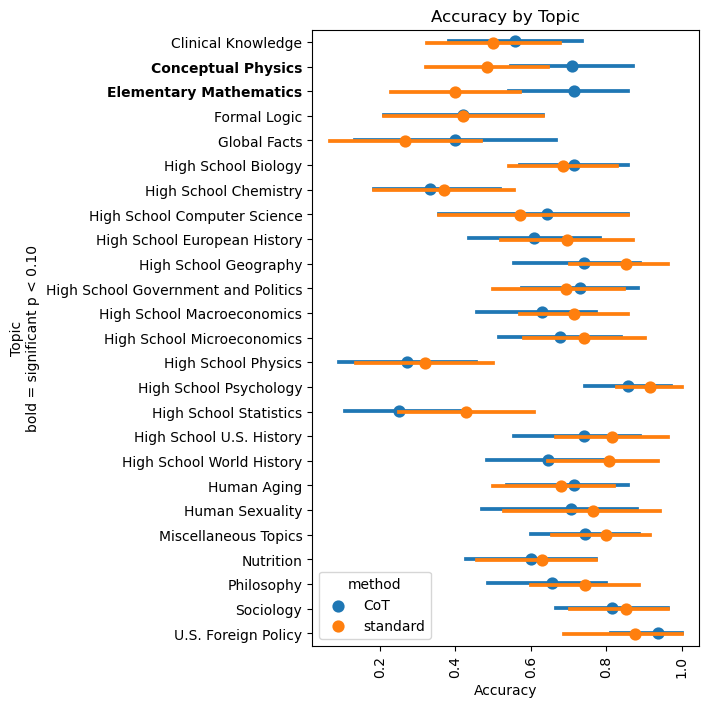

In [6]:
plt.figure(figsize=(5,8))
g = sns.pointplot(data=answer_df, x='is_correct', y='topic', hue='method', dodge=True, join=False, errorbar=('ci',95), orient='h')

# bold sig topics
for tick in g.get_yticklabels():
    if tick.get_text() in sig_topics:
        tick.set_fontweight('bold')

# rename x labels
labels = [config.topic2display[t] for t in topics]
g.set_yticklabels(labels)


plt.xticks(rotation=90)
# show display topics on labels
plt.xlabel('Accuracy')
plt.ylabel('Topic\nbold = significant p < 0.10')
plt.title('Accuracy by Topic')
plt.show()

In [7]:
answer_df['category'] = answer_df['topic'].apply(config.topic2category.get)
cat2pvalue = {}
for category in answer_df['category'].unique():
    scratchpad_correct = answer_df[(answer_df['category']==category) & (answer_df['method']=='CoT')]['is_correct']
    baseline_correct = answer_df[(answer_df['category']==category) & (answer_df['method']=='standard')]['is_correct']
    t, p = ttest_ind(scratchpad_correct, baseline_correct)
    cat2pvalue[category] = p

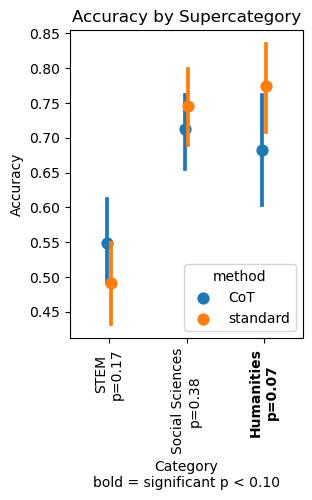

In [8]:
# plot by category
plt.figure(figsize=(3,4))
g = sns.pointplot(data=answer_df, x='category', y='is_correct', hue='method', dodge=True, join=False, errorbar=('ci',95))

# bold sig topics
for tick in g.get_xticklabels():
    if tick.get_text() in cat2pvalue and cat2pvalue[tick.get_text()] < 0.10:
        tick.set_fontweight('bold')

# add p value to labels
labels = [config.category2display[t] + f"\np={cat2pvalue[t]:.2f}" for t in answer_df['category'].unique()]

g.set_xticklabels(labels)

plt.xticks(rotation=90)
# show display topics on labels
plt.xlabel('Category\nbold = significant p < 0.10')
plt.ylabel('Accuracy')

plt.title('Accuracy by Supercategory')
plt.show()

In [6]:
scratchpad_df['is_correct'] = scratchpad_df['answer'] == scratchpad_df['correct_answer']
baseline_df['is_correct'] = baseline_df['answer'] == baseline_df['correct_answer']
# ttest of difference of means
from scipy.stats import ttest_ind

In [11]:
# 95% confidence of scratchpad accuracy
scratchpad_acc = scratchpad_df['is_correct'].mean()
scratchpad_std = scratchpad_df['is_correct'].std()
scratchpad_n = scratchpad_df['is_correct'].count()
scratchpad_ci = 1.96 * scratchpad_std / math.sqrt(scratchpad_n)
print(f'Scratchpad accuracy: {scratchpad_acc:.3f} +/- {scratchpad_ci:.3f}')

Scratchpad accuracy: 0.629 +/- 0.034


In [12]:
# calculate correlation
spearmanr(scratchpad_df['is_correct'], baseline_df['is_correct'])

SpearmanrResult(correlation=0.5732711030814012, pvalue=9.776037131123973e-69)